In [ ]:
# 실전 예제로 주식 데이터(삼성전자, 카카오, 네이버) 를 활용하여
# 주가 변동을 시각화하는 예제를 만들어보겠습니다.
#
# 이 예제에서는 Matplotlib과 Pandas를 활용하여 다음을 분석합니다:
#
# 주가 변동 라인 그래프
# 삼성전자, 카카오, 네이버의 주가 변동을 하나의 그래프로 시각화합니다.
#
# 이동 평균선 추가
# 단기(5일) 및 장기(20일) 이동 평균선을 추가하여 주가 추세를 분석합니다.
#
# 히트맵을 통한 상관관계 분석
# 삼성전자, 카카오, 네이버의 주가 상관관계를 히트맵으로 표현합니다.
#
#
# 1. 주식 데이터 수집 및 처리
# 먼저, 삼성전자(005930), 카카오(035720), 네이버(035420)의 주가 데이터를 가져오겠습니다.
# 실시간 주식 데이터를 사용하기 위해, web을 이용하여 최신 데이터를 검색합니다.
#
# 실전 예제로 삼성전자, 네이버, 카카오의 주가 데이터를 활용하여 주가 변동을 시각화하는 방법을 안내하겠습니다. 이를 통해 주가 변동 추이와 종목 간 상관관계를 분석할 수 있습니다.
#
#
#
# 1. 주가 데이터 수집
# 주가 데이터를 수집하기 위해 yahoo_fin 라이브러리를 사용합니다. 이 라이브러리는 야후 파이낸스에서 주가 데이터를 가져올 수 있도록 도와줍니다.
#
# 필요한 라이브러리 설치:
# !pip install yahoo_fin pandas matplotlib seaborn

In [1]:
# !pip install yahoo_fin pandas matplotlib seaborn
!pip install requests_html

  Using cached urllib3-1.26.20-py2.py3-none-any.whl.metadata (50 kB)
  Using cached websockets-10.4-cp313-cp313-win_amd64.whl
Using cached urllib3-1.26.20-py2.py3-none-any.whl (144 kB)

  Attempting uninstall: websockets

    Found existing installation: websockets 15.0.1

    Uninstalling websockets-15.0.1:

      Successfully uninstalled websockets-15.0.1

  Attempting uninstall: urllib3

    Found existing installation: urllib3 2.5.0

    Uninstalling urllib3-2.5.0:

      Successfully uninstalled urllib3-2.5.0

   -------------------- ------------------- 1/2 [urllib3]
   ---------------------------------------- 2/2 [urllib3]



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.65 requires websockets>=13.0, but you have websockets 10.4 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install yfinance
# 터미널에서도 한번 더 설치 하기.
# pip install yfinance

  Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
Using cached websockets-15.0.1-cp313-cp313-win_amd64.whl (176 kB)
  Attempting uninstall: websockets
    Found existing installation: websockets 10.4
    Uninstalling websockets-10.4:
      Successfully uninstalled websockets-10.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyppeteer 2.0.0 requires websockets<11.0,>=10.0, but you have websockets 15.0.1 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import time
import pandas as pd
import requests

from yahoo_fin import stock_info as si
import yfinance as yf

# ---------------------------
# 1. 종목 코드 설정
# ---------------------------
tickers = {
    '삼성전자': '005930.KS',
    '네이버'  : '035420.KS',
    '카카오'  : '035720.KS'
}

# 헤더 (야후 차단 방지용)
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0.0.0 Safari/537.36"
    )
}

# ---------------------------
# 2. 데이터 수집 함수
# ---------------------------
def get_data_yahoo_fin(ticker, start, end, headers=None):
    return si.get_data(
        ticker,
        start_date=start,
        end_date=end,
        index_as_date=True,
        interval="1d",
        headers=headers
    )

def get_data_yfinance(ticker, start, end):
    df = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=True,
        threads=False
    )
    if df is not None and not df.empty:
        df = df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Adj Close": "adjclose",
            "Volume": "volume"
        })
    return df

def get_data_safe(ticker, start="2022-01-01", end="2025-01-01",
                  retries=3, backoff=2.0, headers=HEADERS):
    last_exc = None
    for i in range(retries):
        try:
            df = get_data_yahoo_fin(ticker, start, end, headers=headers)
            if df is not None and not df.empty:
                return df
        except Exception as e:
            last_exc = e
        time.sleep(backoff * (i + 1))
    # 폴백
    df_fb = get_data_yfinance(ticker, start, end)
    if df_fb is not None and not df_fb.empty:
        return df_fb
    raise RuntimeError(f"Failed to fetch {ticker}") from last_exc

# ---------------------------
# 3. 데이터 수집 및 CSV 저장
# ---------------------------
all_data = {}

for company, ticker in tickers.items():
    try:
        df = get_data_safe(ticker, start="2022-01-01", end="2025-09-01")
        df["company"] = company  # 회사명 컬럼 추가
        all_data[company] = df
        print(f"[OK] {company} ({ticker}) rows={len(df)}")
        time.sleep(0.7)
    except Exception as e:
        print(f"[FAIL] {company} ({ticker}) -> {e}")

# 하나의 DataFrame으로 합치기
combined = pd.concat(all_data.values())
combined.index.name = "date"

# CSV 저장
csv_path = "stock_data.csv"
combined.to_csv(csv_path, encoding="utf-8-sig")
print(f"CSV 저장 완료: {csv_path}")

# ---------------------------
# 4. 저장된 CSV 불러오기
# ---------------------------
loaded = pd.read_csv(csv_path, parse_dates=["date"])
print("불러온 데이터 크기:", loaded.shape)
print(loaded.head())


Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.
[OK] 삼성전자 (005930.KS) rows=895
[OK] 네이버 (035420.KS) rows=895
[OK] 카카오 (035720.KS) rows=895
CSV 저장 완료: stock_data.csv
불러온 데이터 크기: (2685, 9)
        date     open     high      low    close      adjclose    volume  \
0 2022-01-04  78800.0  79200.0  78300.0  78700.0  72762.867188  12427416   
1 2022-01-05  78800.0  79000.0  76400.0  77400.0  71560.937500  25470640   
2 2022-01-06  76700.0  77600.0  76600.0  76900.0  71098.671875  12931954   
3 2022-01-07  78100.0  78400.0  77400.0  78300.0  72393.039062  15163757   
4 2022-01-10  78100.0  78100.0  77100.0  78000.0  72115.687500   9947422   

      ticker company  
0  005930.KS    삼성전자  
1  005930.KS    삼성전자  
2  005930.KS    삼성전자  
3  005930.KS    삼성전자  
4  005930.KS    삼성전자 

In [4]:


# CSV에서 불러온 데이터 활용
# (loaded는 [date, open, high, low, close, adjclose, volume, company] 구조)

# pivot_table 또는 pivot 사용
close_prices = loaded.pivot(index="date", columns="company", values="close")
# 결과 확인
print(close_prices.head())

# 빈 DataFrame 생성
close_prices_alt = pd.DataFrame()

# company별로 close만 추출해 열 단위로 추가
for company in tickers.keys():
    company_df = loaded[loaded["company"] == company]
    close_prices_alt[company] = company_df.set_index("date")["close"]

# 결과 확인
print(close_prices_alt.head())


company          네이버     삼성전자       카카오
date                                   
2022-01-04  365500.0  78700.0  111500.0
2022-01-05  355000.0  77400.0  105500.0
2022-01-06  338500.0  76900.0  100000.0
2022-01-07  338000.0  78300.0  100000.0
2022-01-10  335000.0  78000.0   96600.0
               삼성전자       네이버       카카오
date                                   
2022-01-04  78700.0  365500.0  111500.0
2022-01-05  77400.0  355000.0  105500.0
2022-01-06  76900.0  338500.0  100000.0
2022-01-07  78300.0  338000.0  100000.0
2022-01-10  78000.0  335000.0   96600.0


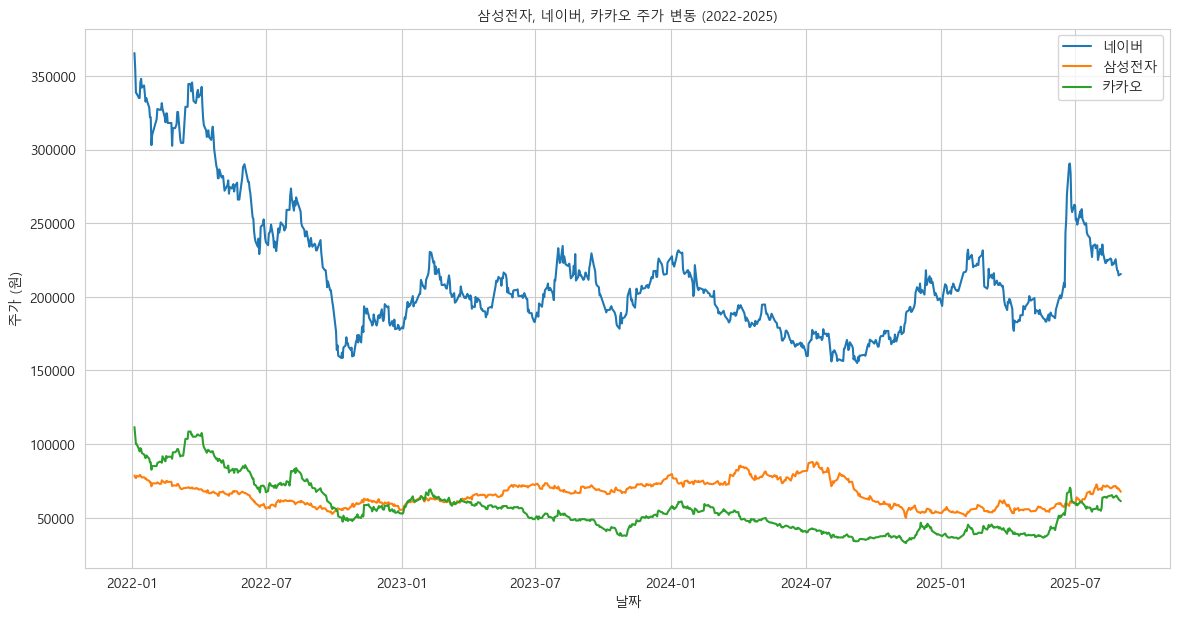

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 경로 설정 (Windows)
font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트 경로

font_prop = fm.FontProperties(fname=font_path)

# Matplotlib 기본 폰트 설정
plt.rcParams['font.family'] = font_prop.get_name()

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(14, 7))
for company in close_prices.columns:
    plt.plot(close_prices.index, close_prices[company], label=company)

plt.title('삼성전자, 네이버, 카카오 주가 변동 (2022-2025)', fontproperties=font_prop)
plt.xlabel('날짜', fontproperties=font_prop)
plt.ylabel('주가 (원)', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.show()

In [ ]:
# 4. 이동 평균선 추가
# 주가의 단기 및 장기 추세를 파악하기 위해 20일 및 60일 이동 평균선을 계산하고 시각화합니다.

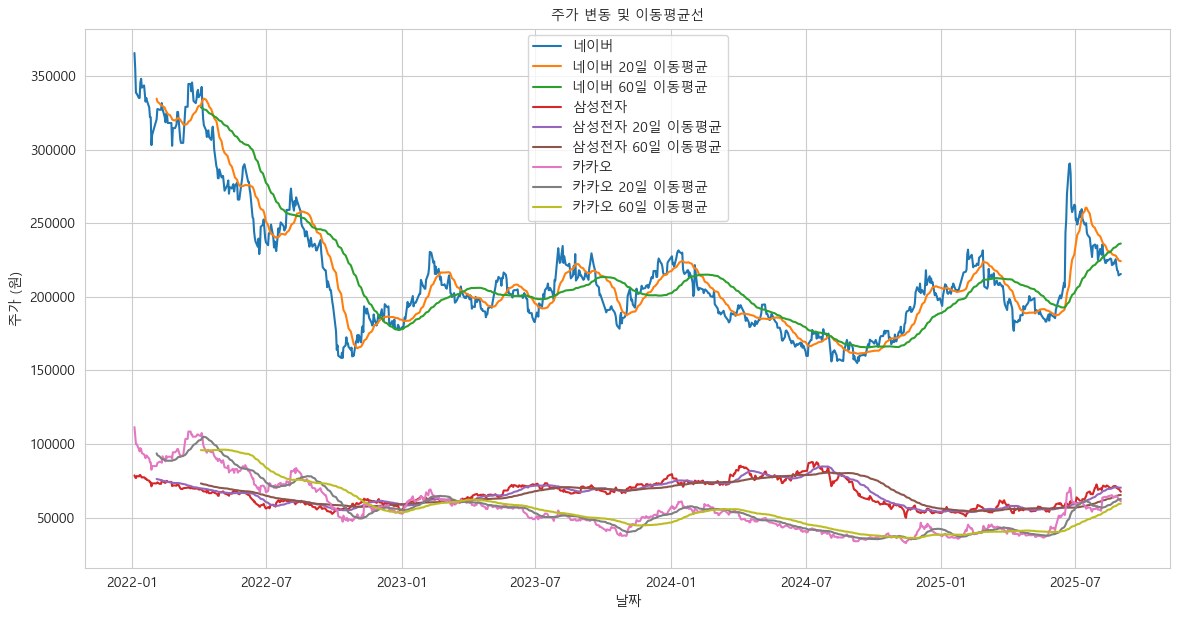

In [7]:
# 이동 평균선 계산
ma_days = [20, 60]
for ma in ma_days:
    for company in close_prices.columns:
        column_name = f'{company} {ma}일 이동평균'
        close_prices[column_name] = close_prices[company].rolling(window=ma).mean()

# 시각화
plt.figure(figsize=(14, 7))
for company in close_prices.columns[:3]:
    plt.plot(close_prices.index, close_prices[company], label=company)
    for ma in ma_days:
        plt.plot(close_prices.index, close_prices[f'{company} {ma}일 이동평균'],
                 label=f'{company} {ma}일 이동평균')

plt.title('주가 변동 및 이동평균선', fontproperties=font_prop)
plt.xlabel('날짜', fontproperties=font_prop)
plt.ylabel('주가 (원)', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True)
plt.show()

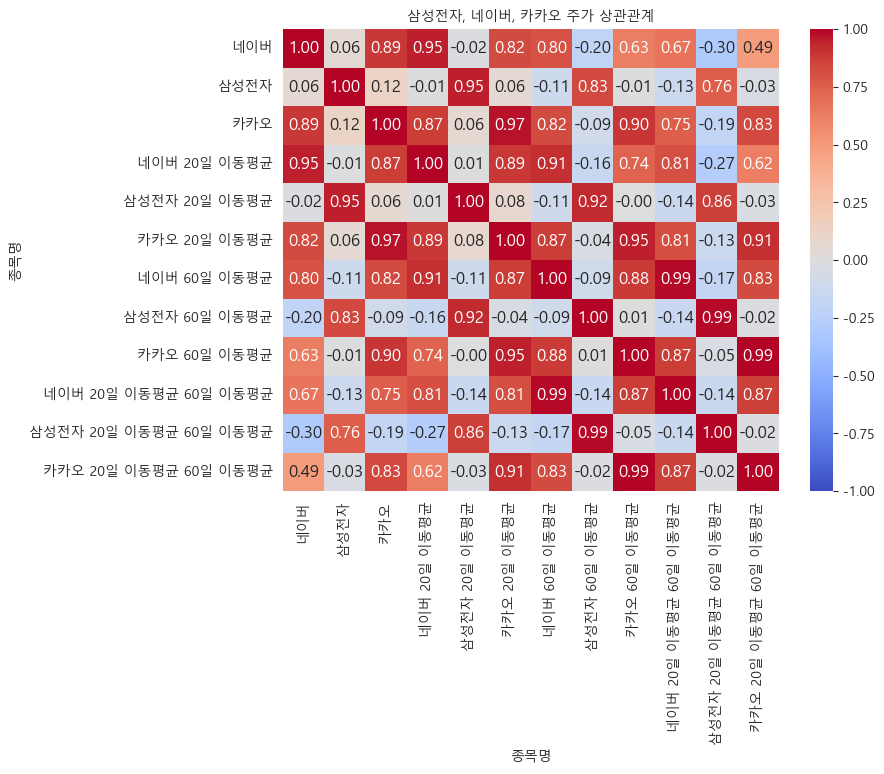

In [8]:
# 📌 종가 데이터의 상관계수 계산
corr = close_prices.corr()

# 📌 히트맵 시각화 (한글 폰트 적용)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            annot_kws={"fontsize": 12, "fontproperties": font_prop}, fmt=".2f")

# 📌 그래프 제목 및 축 레이블 한글 적용
plt.title("삼성전자, 네이버, 카카오 주가 상관관계", fontproperties=font_prop)
plt.xlabel("종목명", fontproperties=font_prop)
plt.ylabel("종목명", fontproperties=font_prop)

plt.show()